## Imports

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import math
import copy
import time

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from skimage.restoration import denoise_nl_means, estimate_sigma

### import utilities  from cyphercat repo
sys.path.insert(0, 'Utils')
import models
from train import *
from metrics import * 



/home/basselmac/anaconda3/envs/modelInversion2env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="cuda:0"
# import pycuda.driver as cuda
# cuda.init()

## Hyperparameters

In [3]:
n_epochs = 100
batch_size = 32
lr = 0.01

In [4]:
attacked_person = 31

## Load AT&t faces dataset

In [5]:
data_dir = "../DATA/att_faces/orl_faces"

img_paths = []
for p in os.listdir(data_dir):
    for i in os.listdir(os.path.join(data_dir, p)):
        img_paths.append(os.path.join(data_dir, p, i))

people = []
people_to_idx = {}

k=0
for i in img_paths:
    name = i.split('/')[4]
    if name not in people_to_idx:
        people.append(name)
        people_to_idx[name] = k
        k += 1


In [6]:
img_paths = np.random.permutation(img_paths)
att_size = len(img_paths)
att_train_size = int(0.7 * att_size)

att_train_list = img_paths[:att_train_size]
att_test_list = img_paths[att_train_size:]

In [7]:
class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        self.people_to_idx = class_to_label

    def __len__(self): 
        return len(self.file_list)

    def __getitem__(self, idx): 
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
#         image[:,:,1]= im
#         image[:,:,2]= im

        label = self.people_to_idx[img_path.split('/')[4]]
        
        if self.transform is not None: 
            image = self.transform(image)
        return image, label

## Data Augmentation

In [8]:
train_transform = torchvision.transforms.Compose([
    # TODO try different data tranforms
    
    # Convert numpy.ndarray to tensor.
    torchvision.transforms.ToTensor(),
    
    # Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn)
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    # TODO try different data tranforms
    
    # Convert numpy.ndarray to tensor.
    torchvision.transforms.ToTensor(),
    
    # Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn)
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])


In [9]:
# train/test split
trainset = ATTdataset(att_train_list, people_to_idx, transform=train_transform)
testset = ATTdataset(att_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(att_test_list, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=1, shuffle=False, num_workers=2)
                                           

tensor([ 6, 21,  8, 10, 28, 35, 36, 25,  3, 30, 39,  8, 21, 31, 12, 23, 21, 17,
         0, 23,  1, 32,  1, 38,  5, 36, 31, 15, 17, 23, 39, 35])
tensor(-1.)
tensor(0.9216)
torch.Size([32, 1, 112, 92])


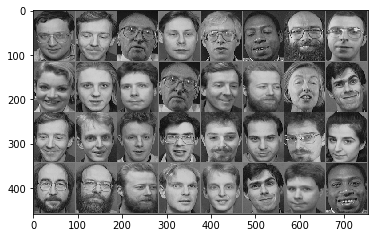

In [10]:
# helper function to un-normalize and plot image
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)

# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [11]:
# 1 hidden layer only
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40): 
        super(mlp, self).__init__()
        # Applies a linear transformation to the incoming data: y = xA^T + b
        self.hidden1 = nn.Linear(n_in, n_out)        

    def forward(self, x):

        x = x.view(-1,112*92)
        out = self.hidden1(x)
        return out



In [12]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = mlp().to(device)
net.apply(models.weights_init)

net2 = mlp().to(device)
net2.apply(models.weights_init)

criterion = nn.CrossEntropyLoss()
# two diffrent optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


ww0 = copy.deepcopy(net2.hidden1.weight.data)
bb = copy.deepcopy(net2.hidden1.bias.data[:])
im0 = ww0[attacked_person].reshape(112,92)


## training

[0/100]
Training:

Accuracy = 67.50 %


Test:

Accuracy = 47.50 %




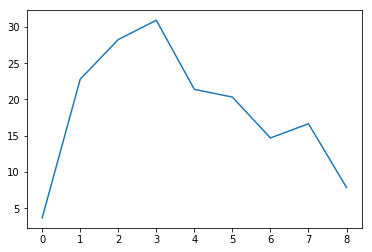

[1/100]
Training:

Accuracy = 91.79 %


Test:

Accuracy = 71.67 %




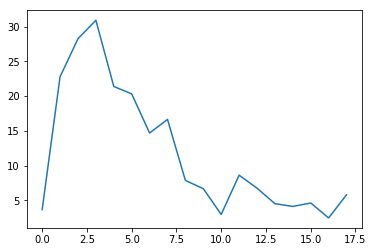

[2/100]
Training:

Accuracy = 96.07 %


Test:

Accuracy = 87.50 %




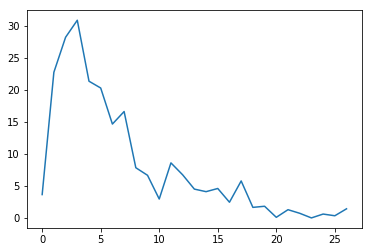

[3/100]
Training:

Accuracy = 96.43 %


Test:

Accuracy = 78.33 %




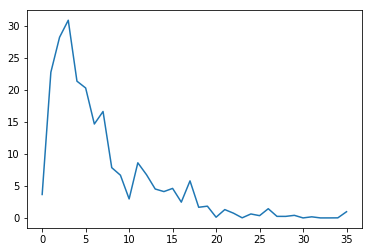

[4/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 86.67 %




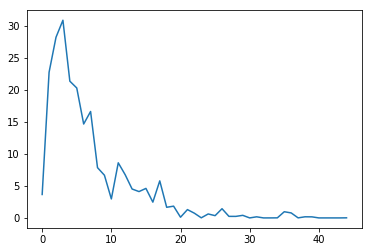

[5/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 81.67 %




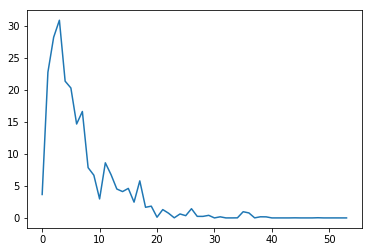

[6/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 78.33 %




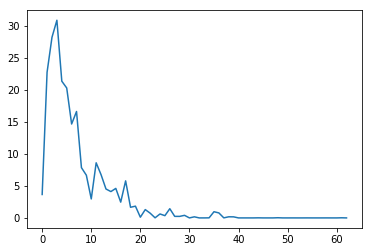

[7/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




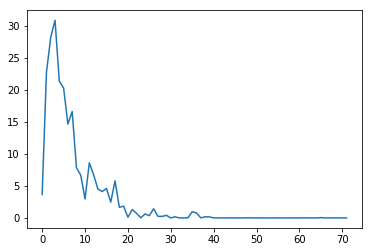

[8/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




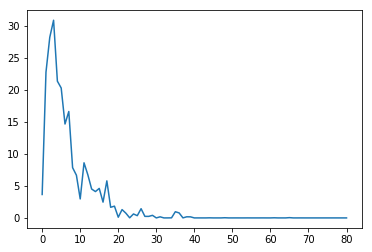

[9/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 82.50 %




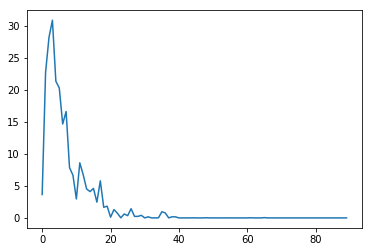

[10/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




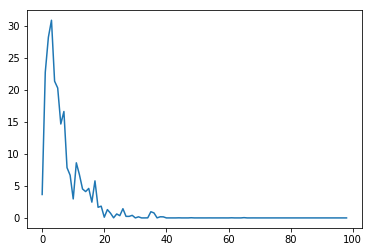

[11/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




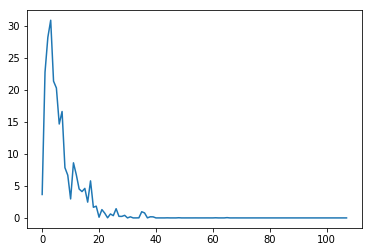

[12/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




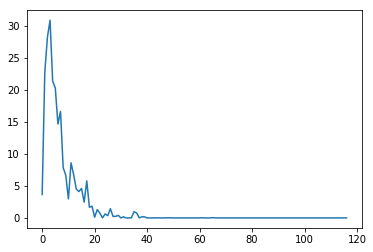

[13/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




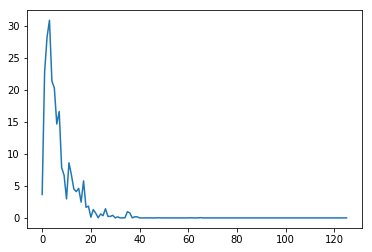

[14/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




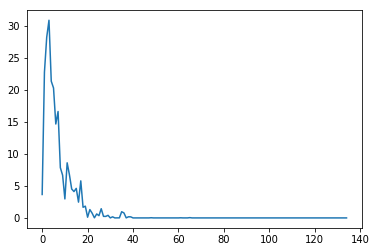

[15/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




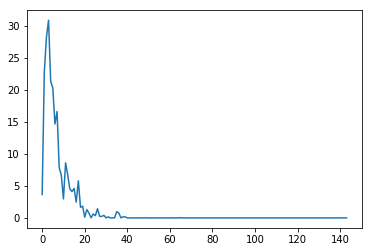

[16/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




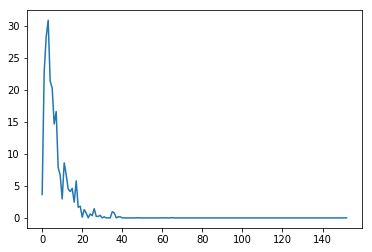

[17/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




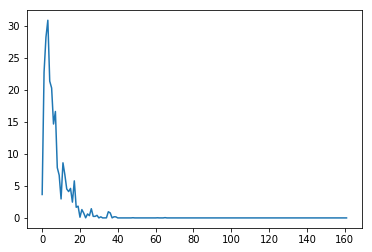

[18/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




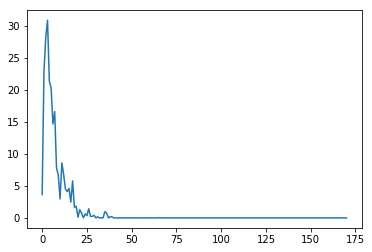

[19/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




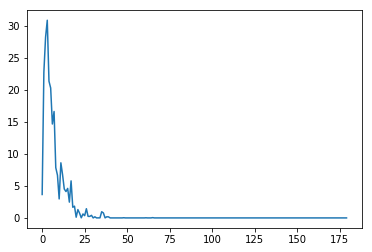

[20/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




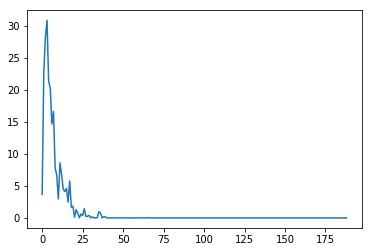

[21/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




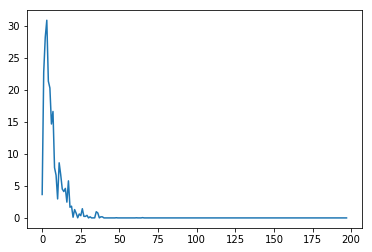

[22/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




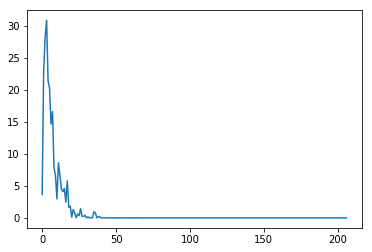

[23/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




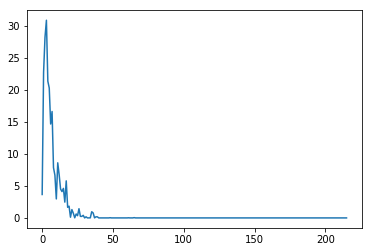

[24/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




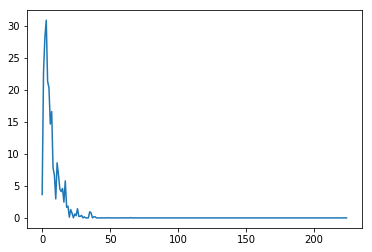

[25/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




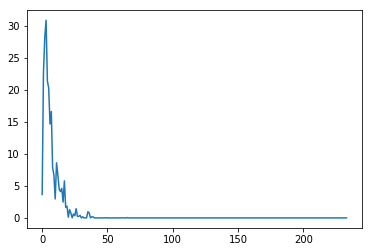

[26/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




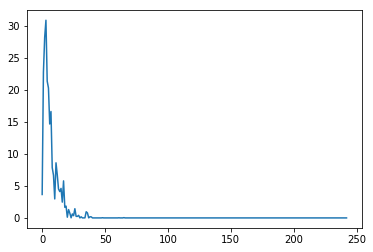

[27/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




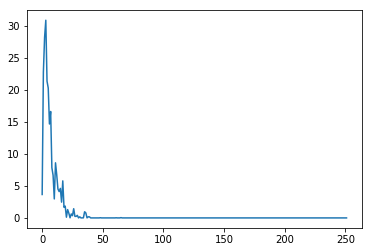

[28/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




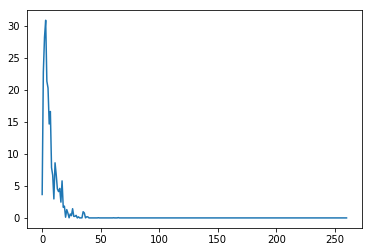

[29/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




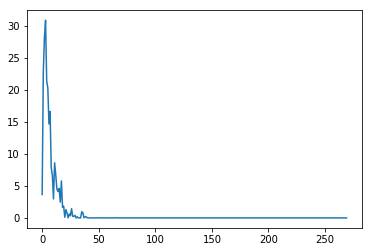

[30/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




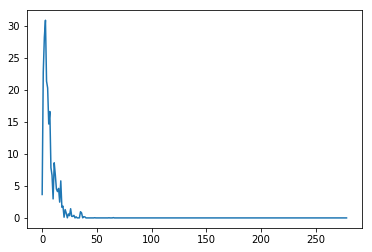

[31/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




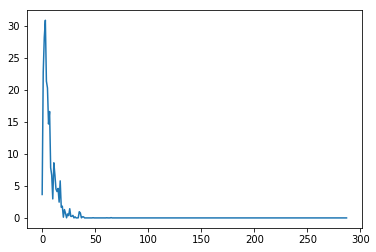

[32/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




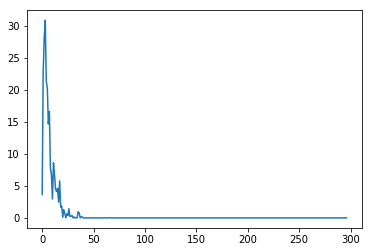

[33/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




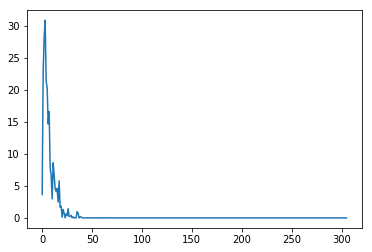

[34/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




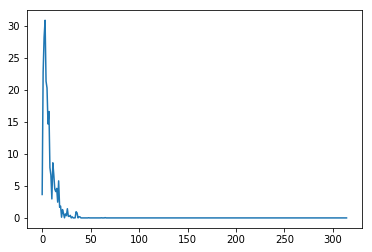

[35/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




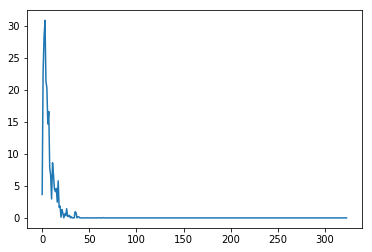

[36/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




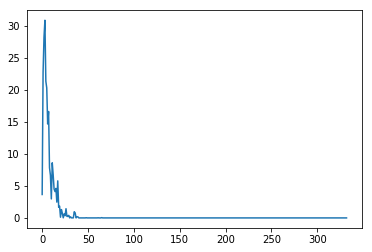

[37/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




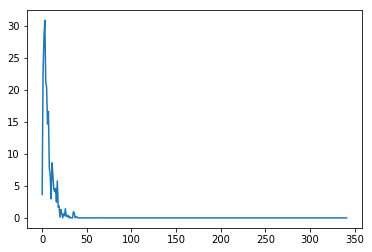

[38/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




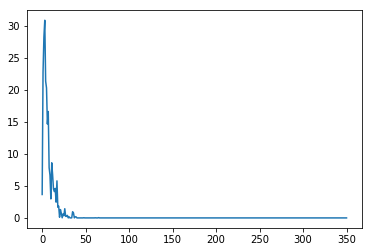

[39/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




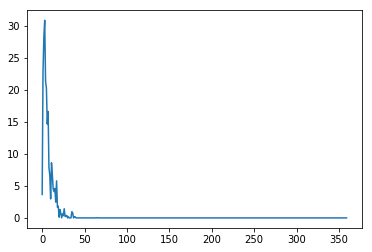

[40/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




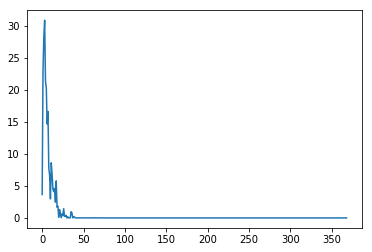

[41/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




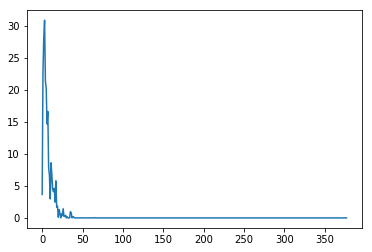

[42/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




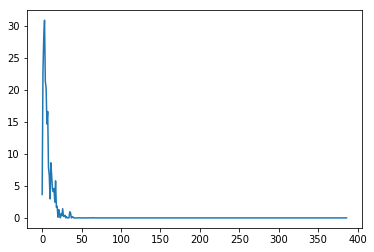

[43/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




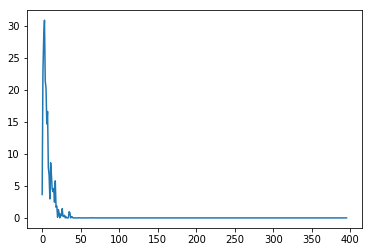

[44/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




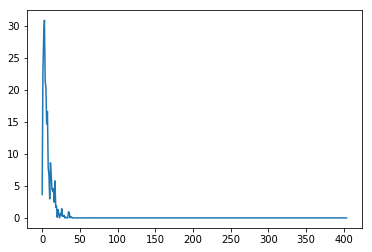

[45/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




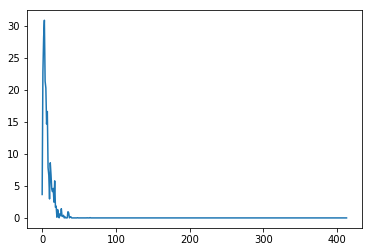

[46/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




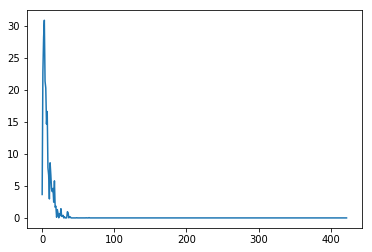

[47/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




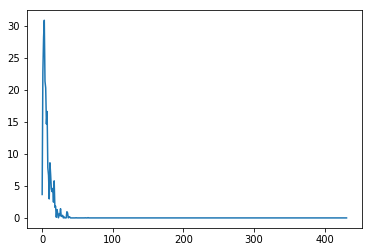

[48/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




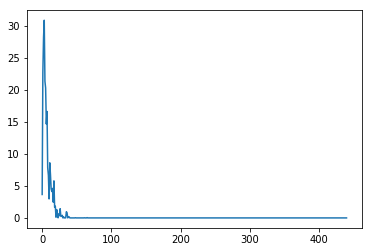

[49/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




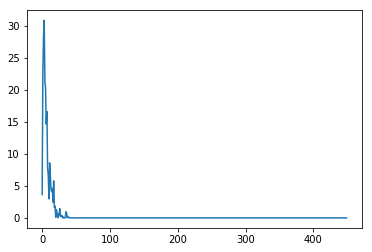

[50/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




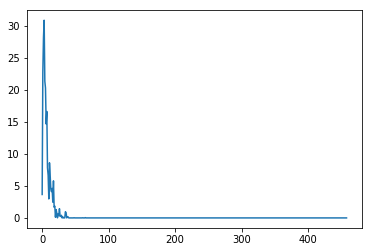

[51/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




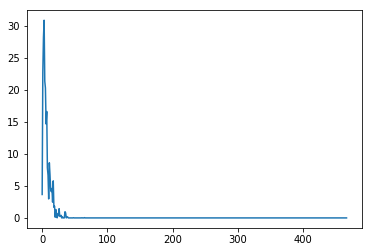

[52/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




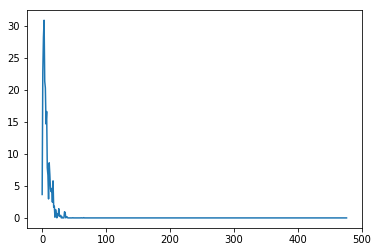

[53/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




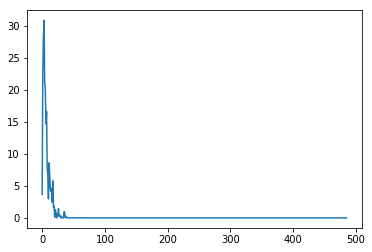

[54/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




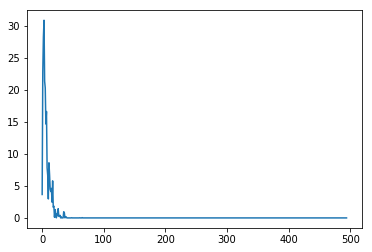

[55/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




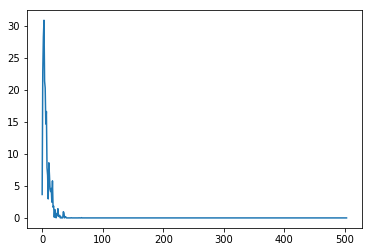

[56/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




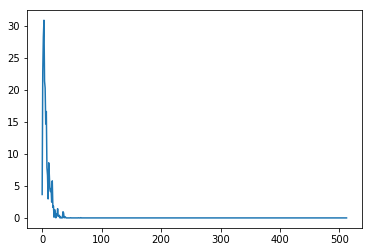

[57/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




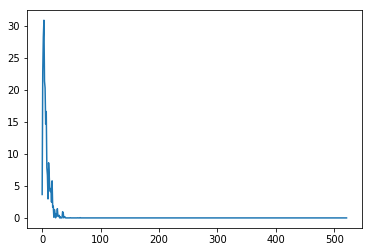

[58/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




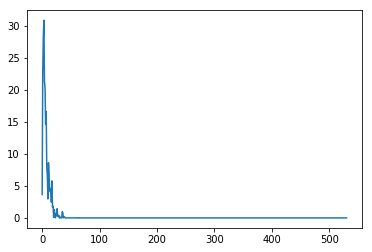

[59/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




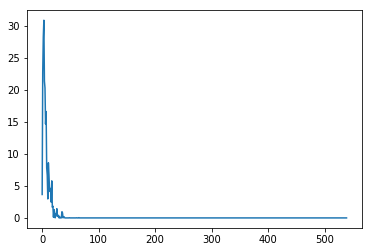

[60/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




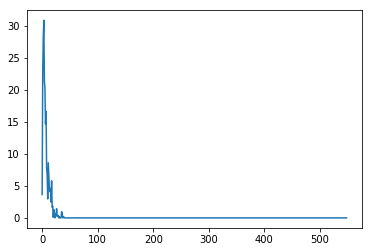

[61/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




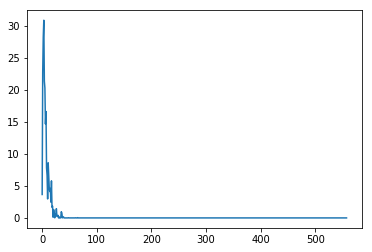

[62/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




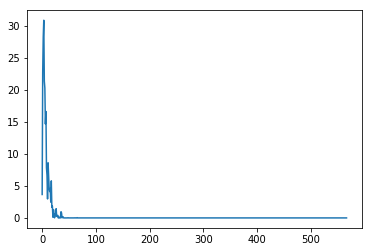

[63/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




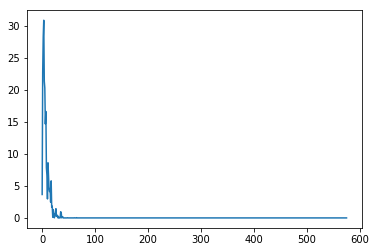

[64/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




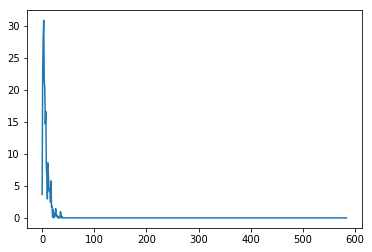

[65/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




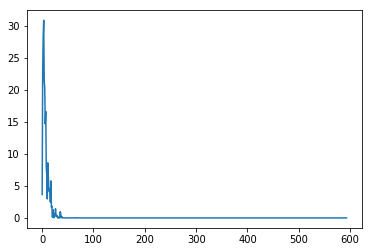

[66/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




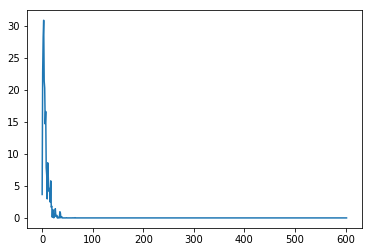

[67/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




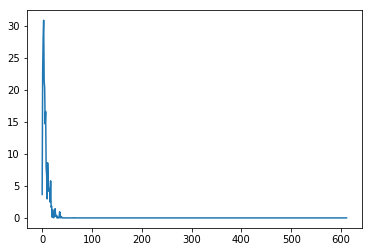

[68/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




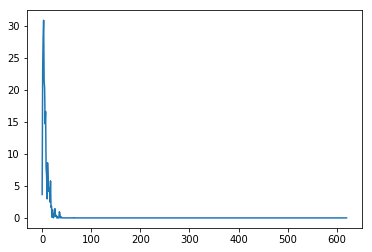

[69/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




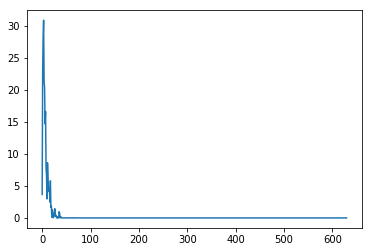

[70/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




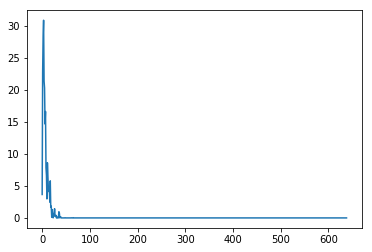

[71/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




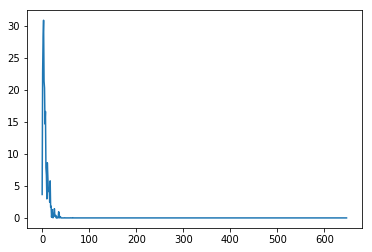

[72/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




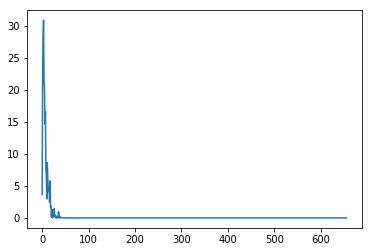

[73/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




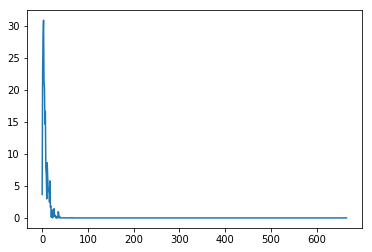

[74/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




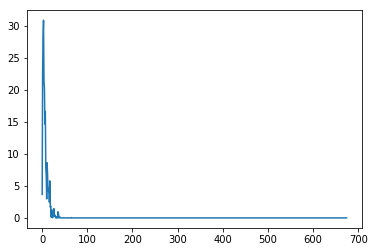

[75/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




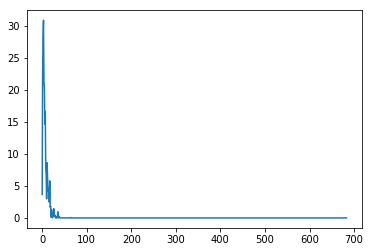

[76/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




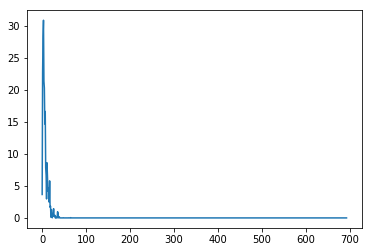

[77/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




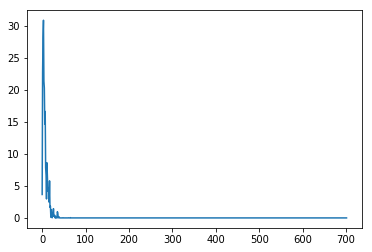

[78/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




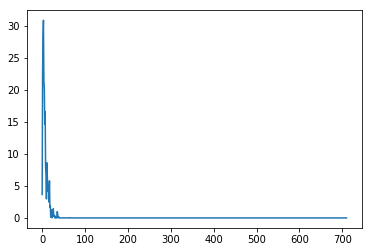

[79/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




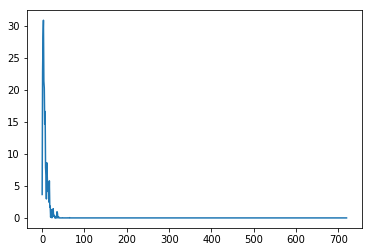

[80/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




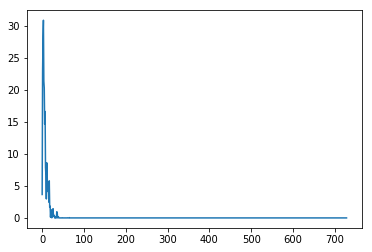

[81/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




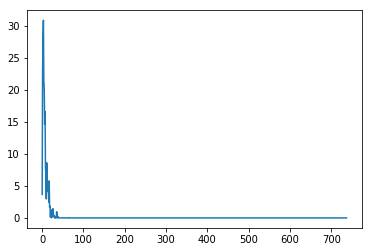

[82/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




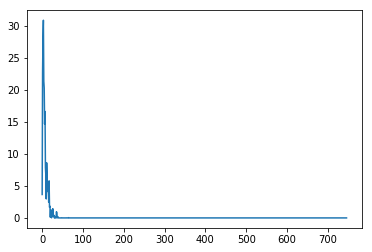

[83/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




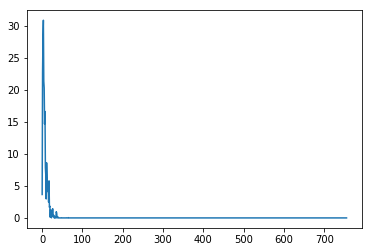

[84/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




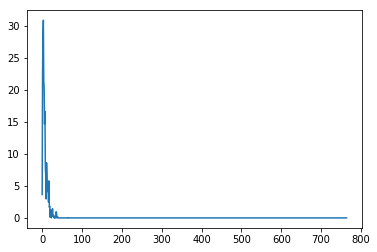

[85/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




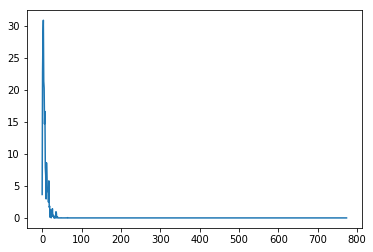

[86/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




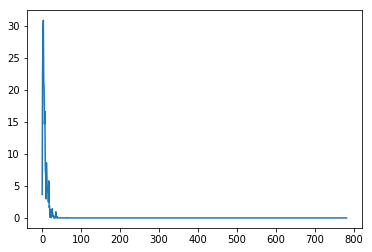

[87/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




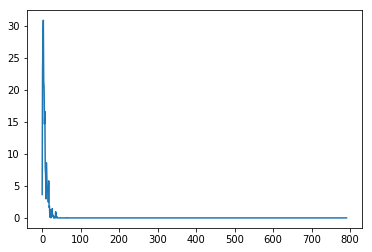

[88/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




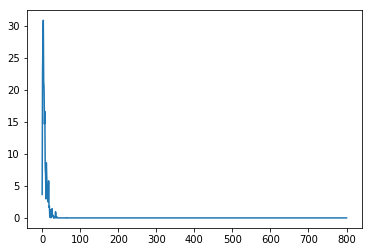

[89/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




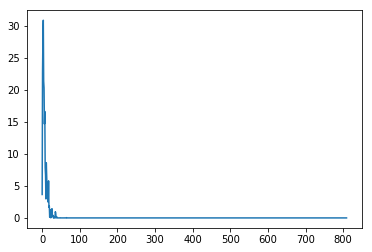

[90/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




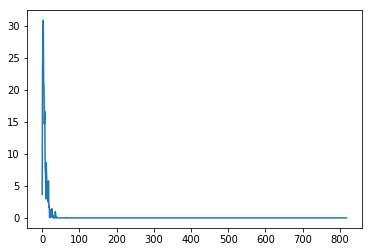

[91/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




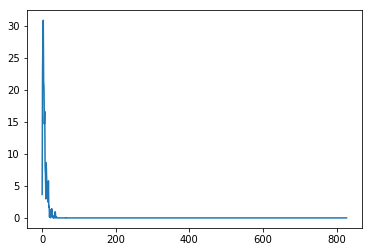

[92/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




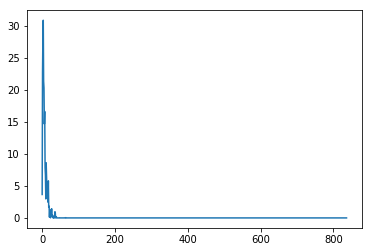

[93/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




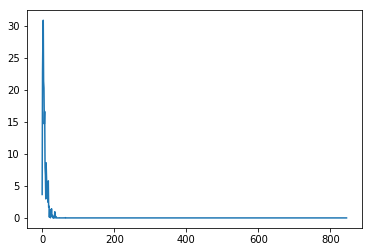

[94/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




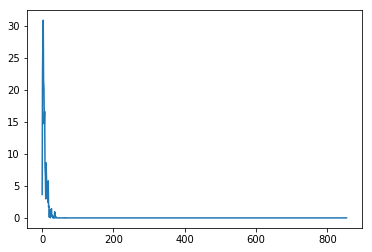

[95/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




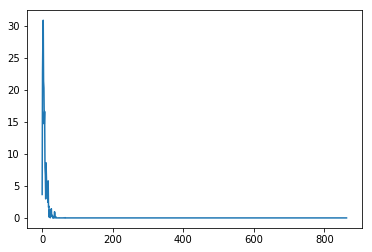

[96/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




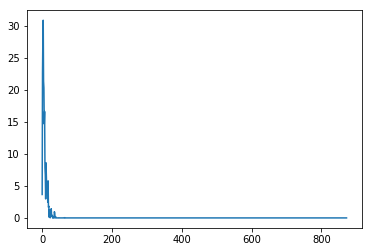

[97/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




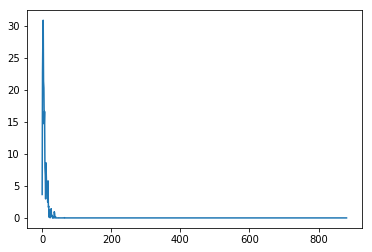

[98/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




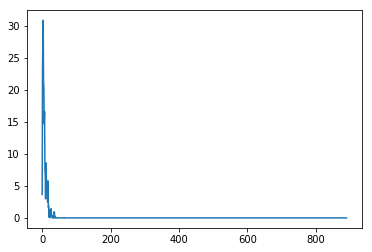

[99/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 83.33 %




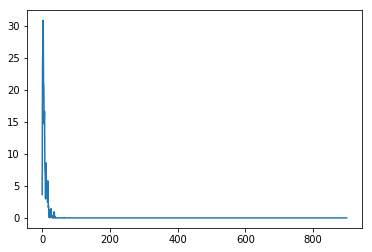

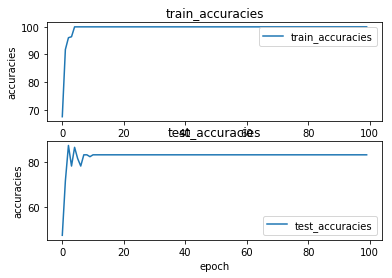

62.565722942352295 seconds


In [13]:
t0 = time.time()
accuracy,loss=train(net, trainloader, testloader, optimizer, criterion, n_epochs, verbose=False)
print('{} seconds'.format(time.time() - t0))

[0/100]
Training:

Accuracy = 76.79 %


Test:

Accuracy = 51.67 %




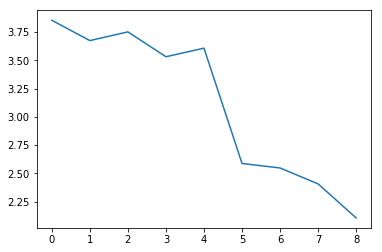

[1/100]
Training:

Accuracy = 94.64 %


Test:

Accuracy = 77.50 %




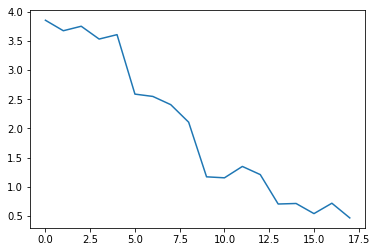

[2/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 90.00 %




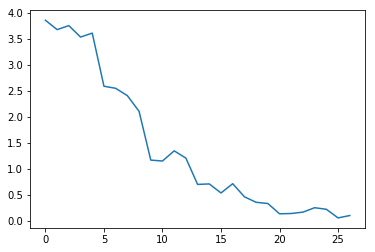

[3/100]
Training:

Accuracy = 99.64 %


Test:

Accuracy = 87.50 %




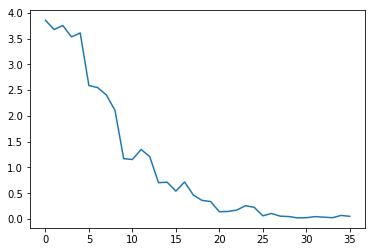

[4/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 89.17 %




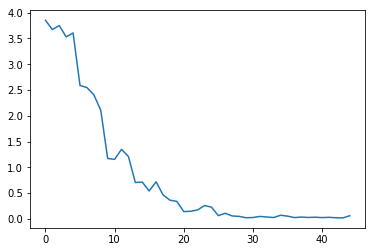

[5/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 90.00 %




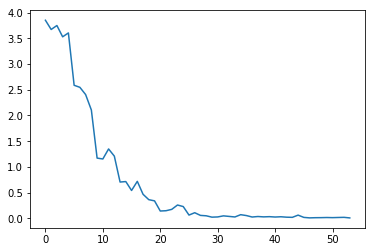

[6/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 90.83 %




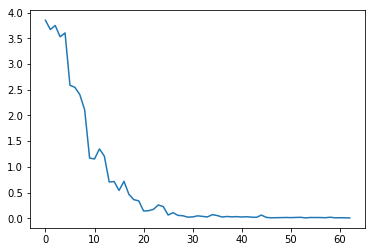

[7/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 91.67 %




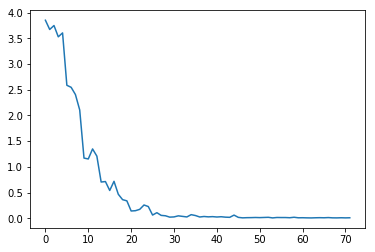

[8/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




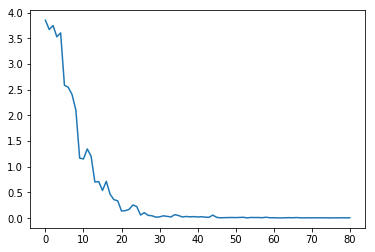

[9/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




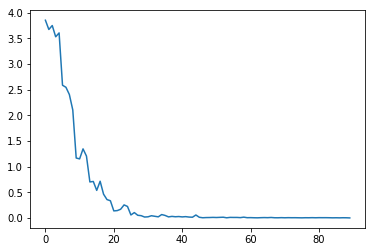

[10/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




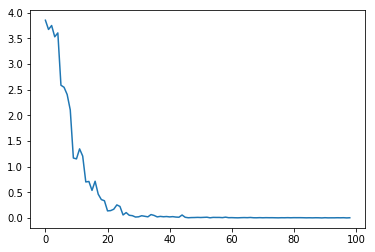

[11/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




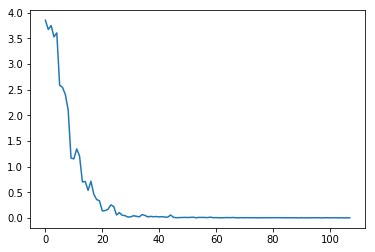

[12/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




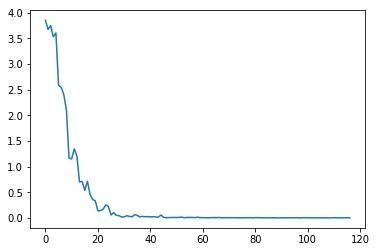

[13/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




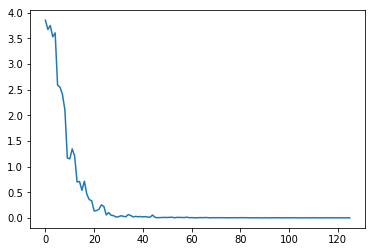

[14/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




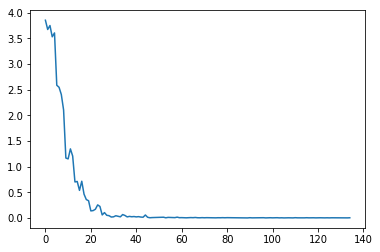

[15/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




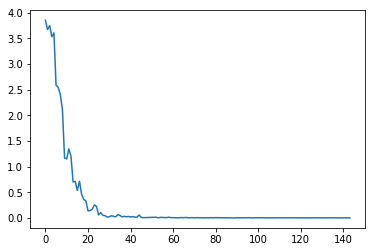

[16/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 92.50 %




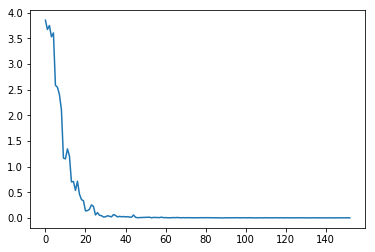

[17/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




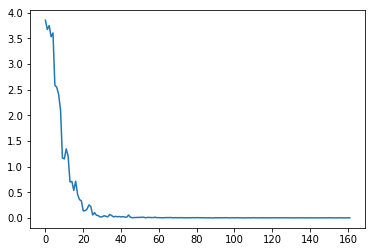

[18/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




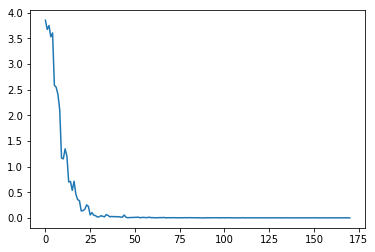

[19/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




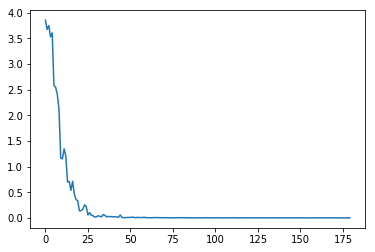

[20/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




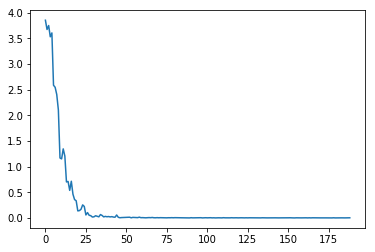

[21/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 93.33 %




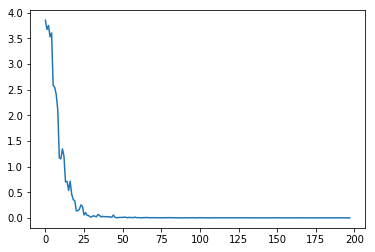

[22/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




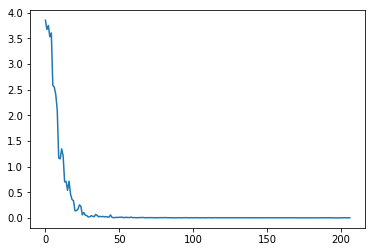

[23/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




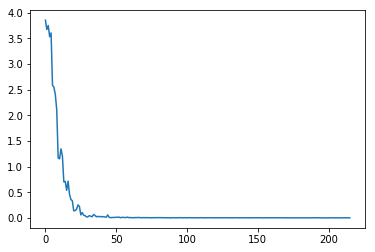

[24/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




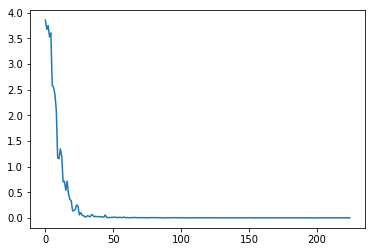

[25/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




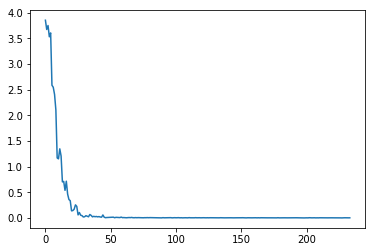

[26/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




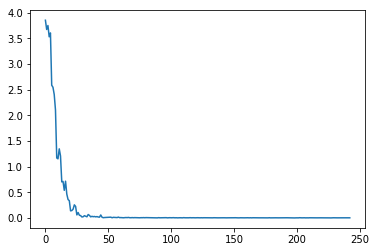

[27/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




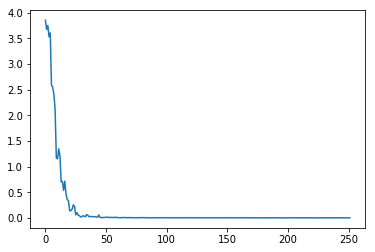

[28/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




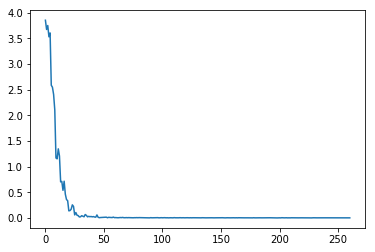

[29/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




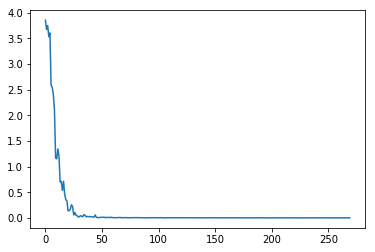

[30/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




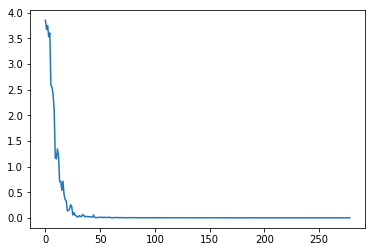

[31/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




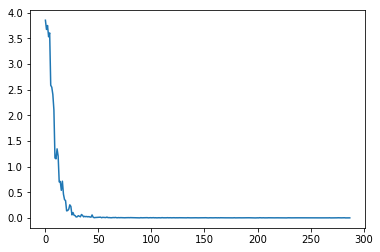

[32/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




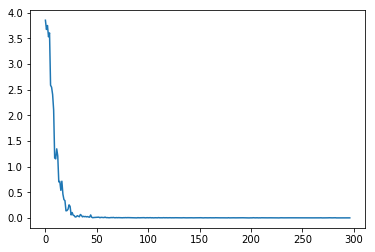

[33/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 94.17 %




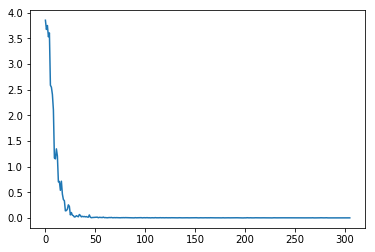

[34/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




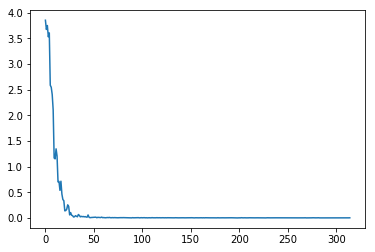

[35/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




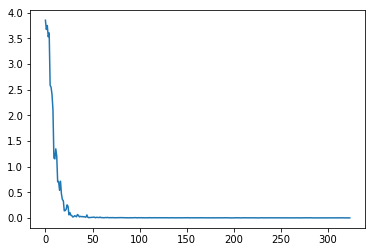

[36/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




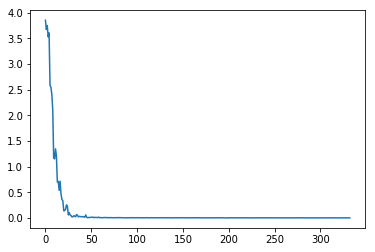

[37/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




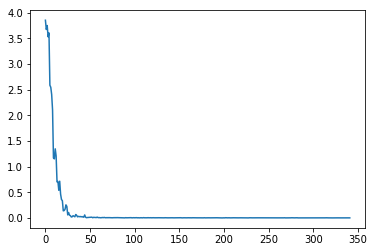

[38/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




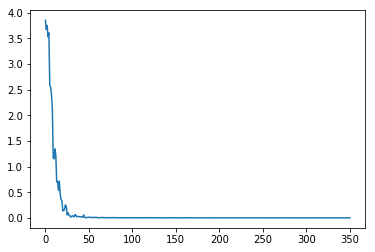

[39/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




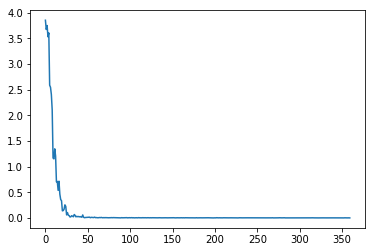

[40/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




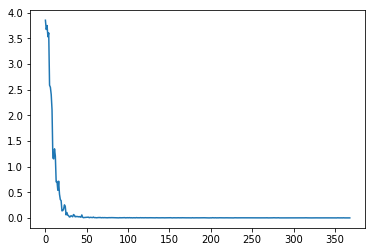

[41/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




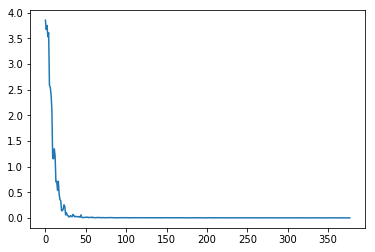

[42/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




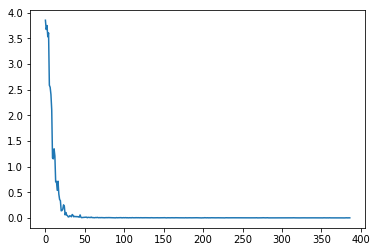

[43/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




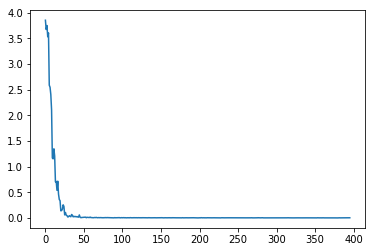

[44/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




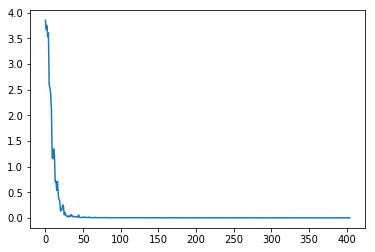

[45/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




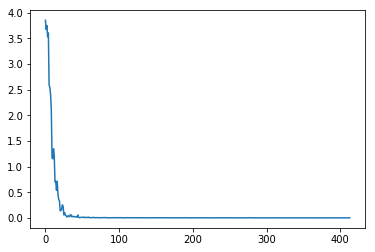

[46/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




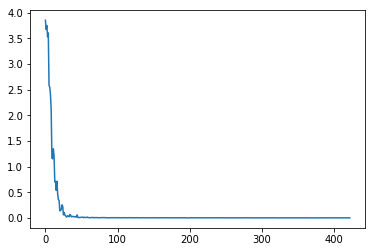

[47/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




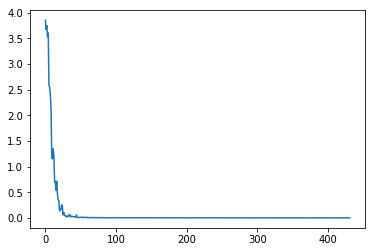

[48/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




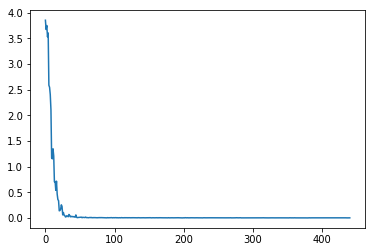

[49/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




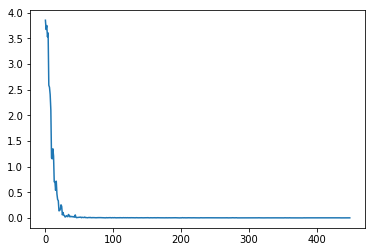

[50/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




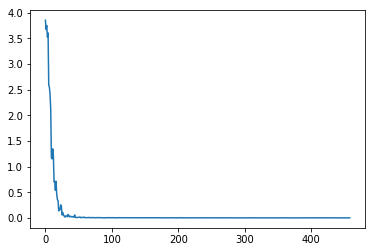

[51/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




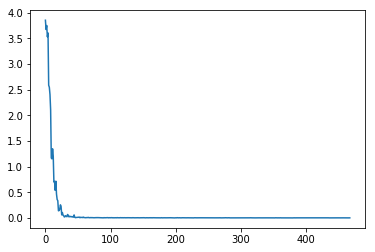

[52/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




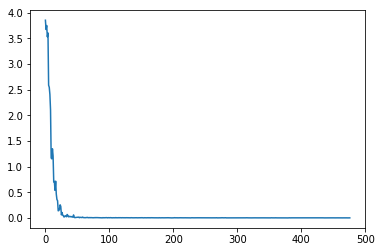

[53/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




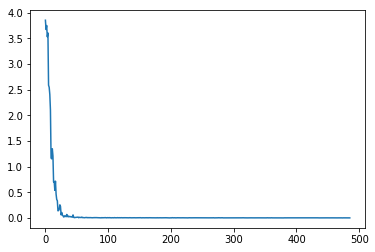

[54/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




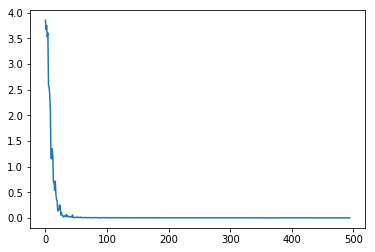

[55/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




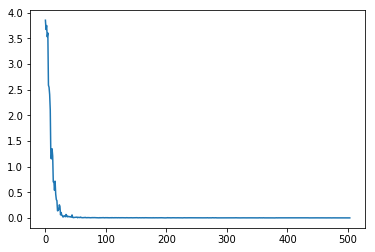

[56/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




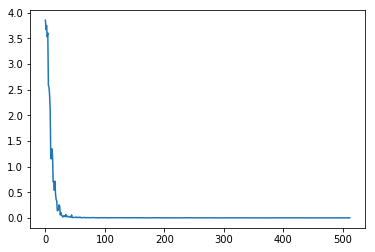

[57/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




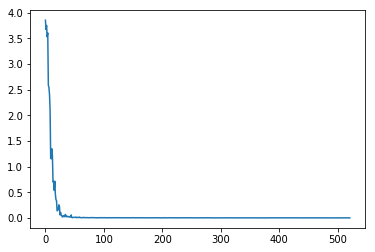

[58/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




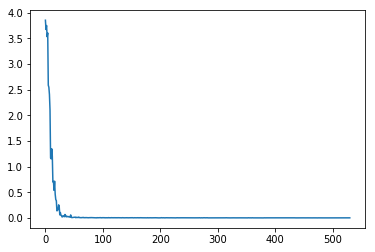

[59/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




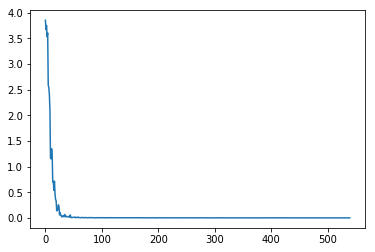

[60/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




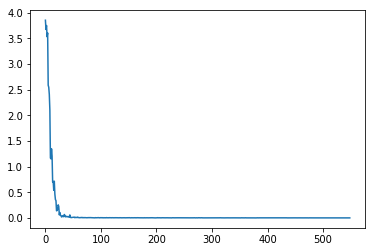

[61/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




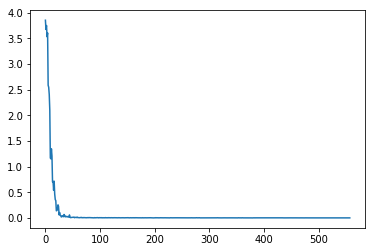

[62/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




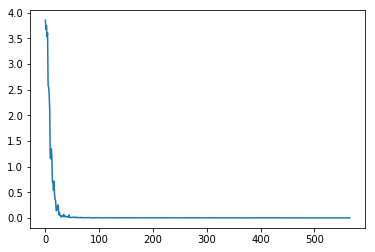

[63/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




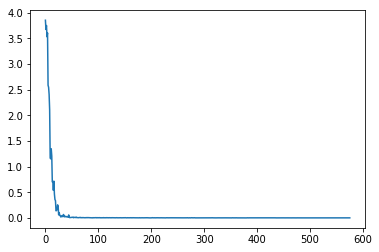

[64/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




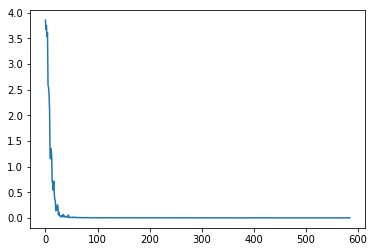

[65/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




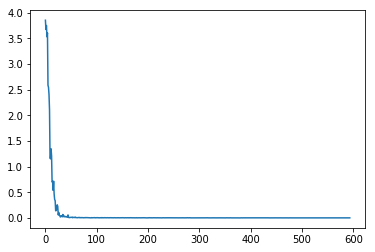

[66/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




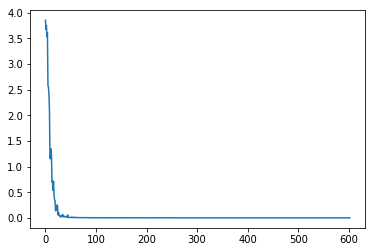

[67/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




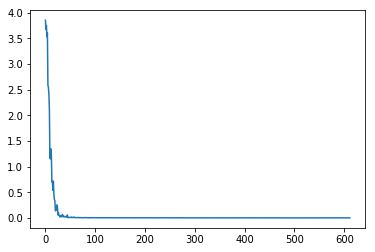

[68/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




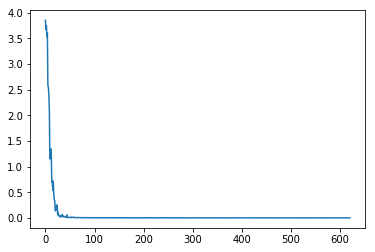

[69/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




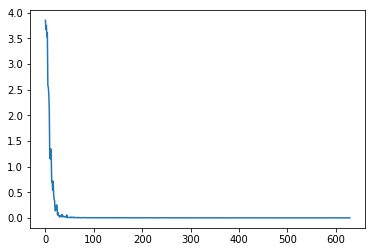

[70/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




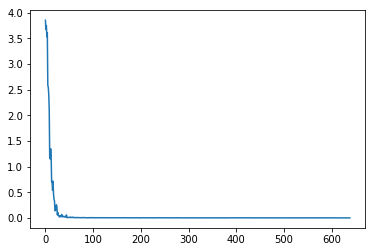

[71/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




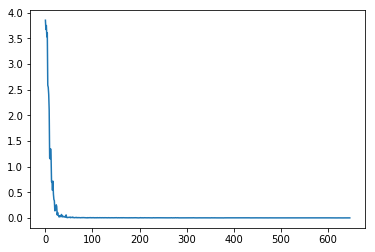

[72/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




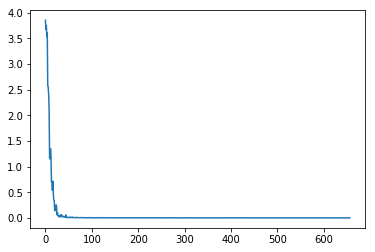

[73/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




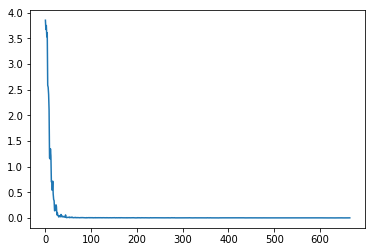

[74/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




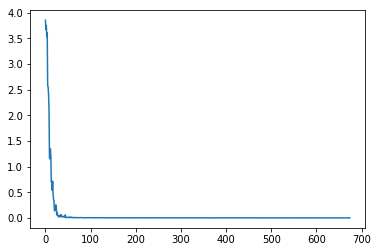

[75/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




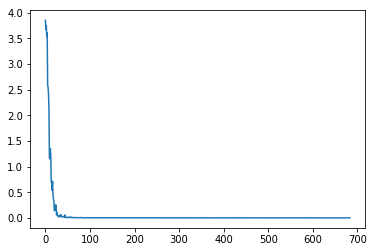

[76/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




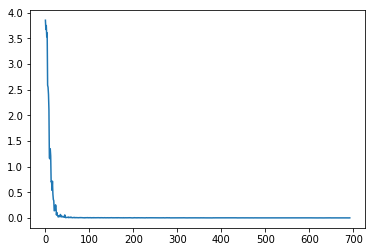

[77/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




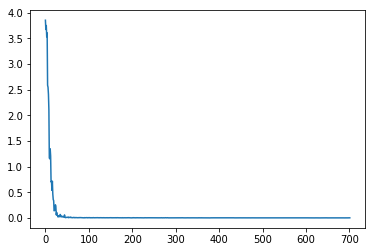

[78/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




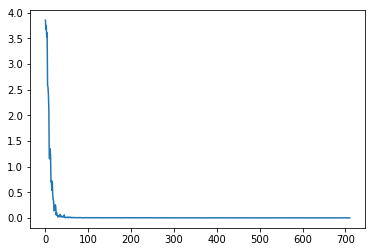

[79/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




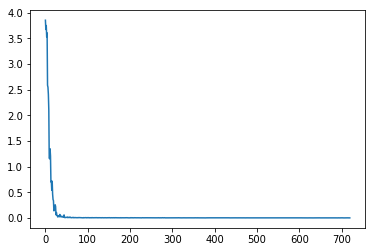

[80/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




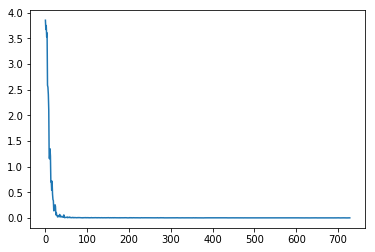

[81/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




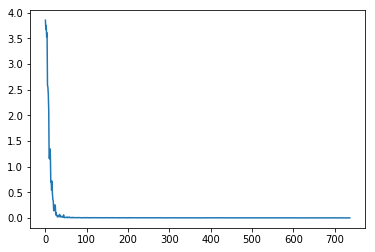

[82/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




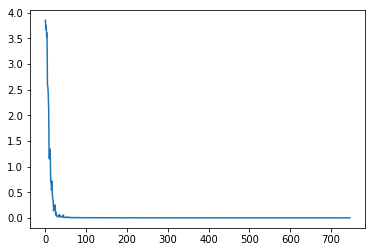

[83/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




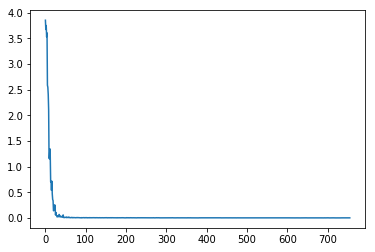

[84/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




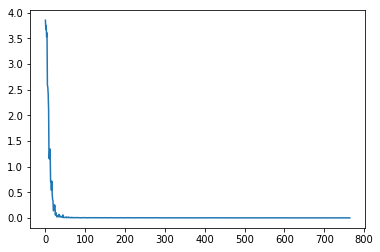

[85/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




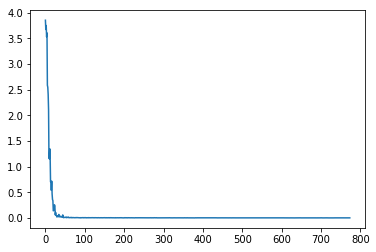

[86/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




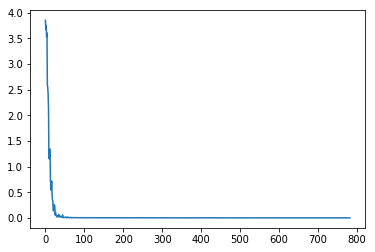

[87/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




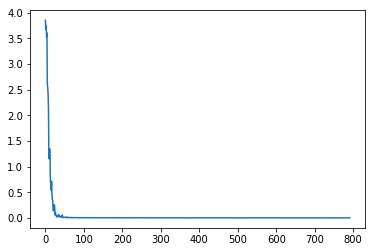

[88/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




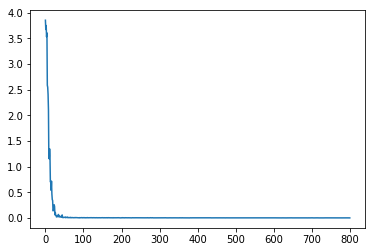

[89/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




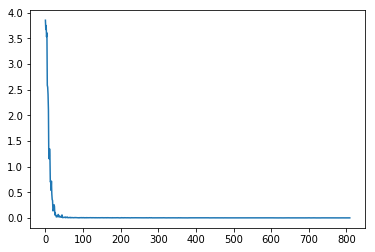

[90/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




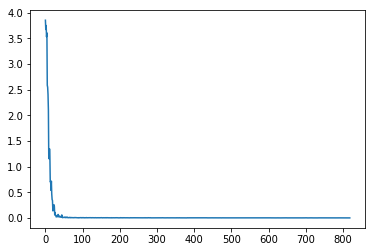

[91/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




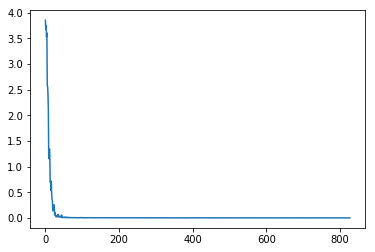

[92/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




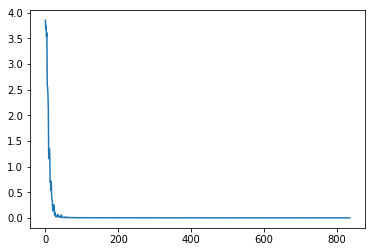

[93/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




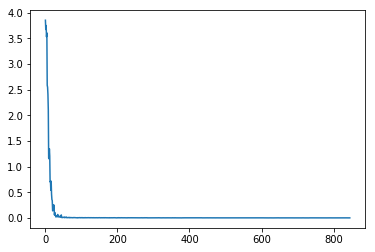

[94/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




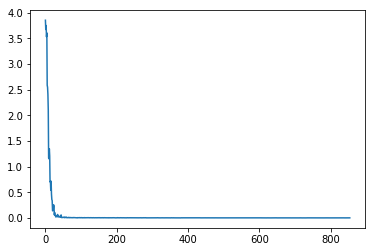

[95/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




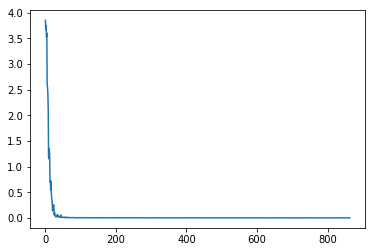

[96/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




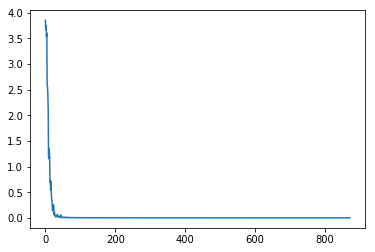

[97/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




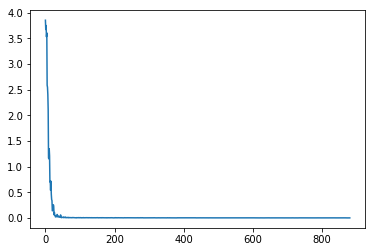

[98/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




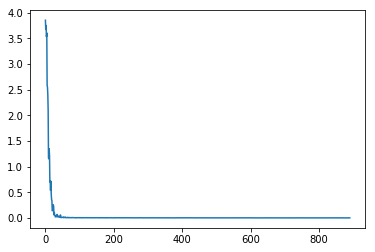

[99/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %




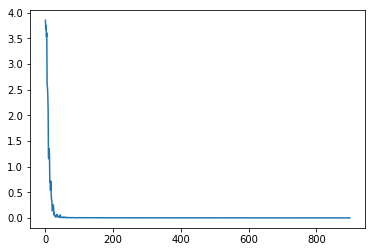

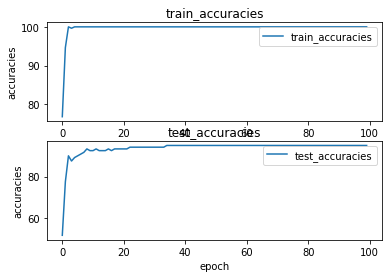

62.408186197280884 seconds


In [14]:
t0 = time.time()
train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)
print('{} seconds'.format(time.time() - t0))

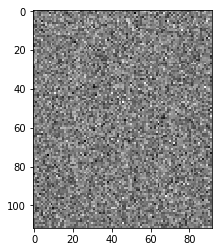

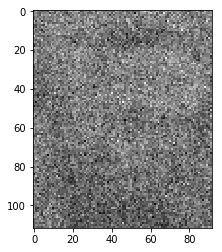

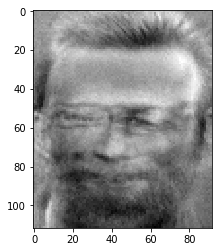

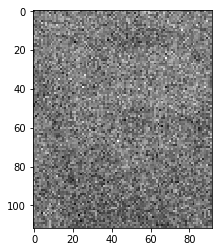

In [15]:
ww = net2.hidden1.weight.data[:]
bb = net2.hidden1.bias.data[:]
im0CPU = im0.cpu().detach().numpy()

im_train = ww[attacked_person,:].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im0CPU,cmap='gray')
plt.show()

plt.imshow(im_train,cmap='gray')
plt.show()

plt.imshow(im_train-im0CPU,cmap='gray')
plt.show()

randimg = torch.randn(im_train.shape).cpu().detach().numpy()/100
plt.imshow(im_train-randimg,cmap='gray')
plt.show()


## Gradient Ascent



In [16]:
from torch.autograd import Variable

def ga(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    inputVar = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    grad0 = np.zeros((112,92))
    for j in range(iterations):
        for i in range(1):
            # set the gradients of all model parameters to zero
            net.zero_grad()
#             out = nn.functional.softmax(net(input), dim=1)
            out = net(inputVar)
            loss= -out.take(category)#+reg_alpha
            loss.backward()
            inputVar.data = inputVar.data - lr * inputVar.grad.data
            inputVar.grad.zero_()
        losses.append(loss.data)
#         print(j)
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    return inputVar


### Overfitted model

Gradient Ascent optimizes an input image to maximize the posterior of a particular category.

Gradient Ascent reconstructs the memorized image within the parameters. If the model is well generalized with a lower learning rate and higher testing accuracy the method is not as effective. Although new results show that if the initial model parameters are subtracted from the reconstruction an accurate reconstruction will be generated.

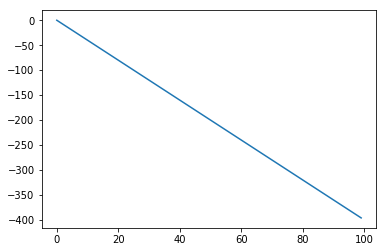

0.4015369415283203 seconds


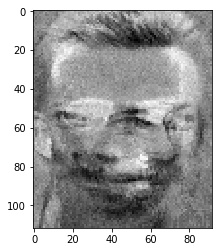

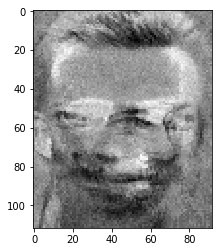

In [17]:
# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))
t0 = time.time()
dream_ga=ga(torch.Tensor((np_page)),net,100,1e-1,attacked_person)
print('{} seconds'.format(time.time() - t0))
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0CPU,cmap='gray')
plt.show()

## More generalized model

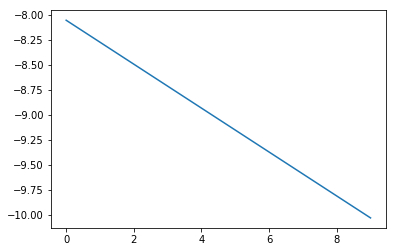

0.09888434410095215 seconds


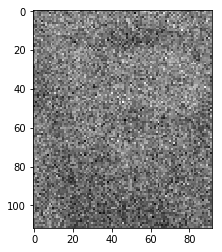

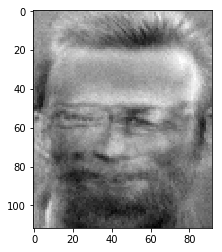

In [18]:
# np_page=np.random.random((112,92))
# np_page=np.zeros((112,92))
np_page=np.ones((112,92))
t0 = time.time()
dream_ga=ga(torch.Tensor((np_page)),net2,10,1e-1,attacked_person)
print('{} seconds'.format(time.time() - t0))
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
# plt.imsave("noisy.png",dream_ga.squeeze().cpu().detach().numpy(),cmap = 'gray',format='png')
# plt.imsave("noise.png",im0,cmap = 'gray',format='png')
# plt.imsave("noisy-noise.png",dream_ga.squeeze().cpu().detach().numpy()-im0,cmap = 'gray',format='png')
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0CPU,cmap='gray')
plt.show()

## Regularization

In [33]:
alpha_reg_alpha = 6
def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm


def ga_norm(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = torch.sigmoid(net(input))
#             out = net(input)
            reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
            loss= -out.take(category)+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
#         plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
#         plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

0
tensor([-0.5002], device='cuda:0')
tensor([-0.5002], device='cuda:0', grad_fn=<NegBackward>)
1
tensor([-0.5139], device='cuda:0')
tensor([-0.5139], device='cuda:0', grad_fn=<NegBackward>)
2
tensor([-0.5276], device='cuda:0')
tensor([-0.5276], device='cuda:0', grad_fn=<NegBackward>)
3
tensor([-0.5412], device='cuda:0')
tensor([-0.5412], device='cuda:0', grad_fn=<NegBackward>)
4
tensor([-0.5547], device='cuda:0')
tensor([-0.5547], device='cuda:0', grad_fn=<NegBackward>)
5
tensor([-0.5681], device='cuda:0')
tensor([-0.5681], device='cuda:0', grad_fn=<NegBackward>)
6
tensor([-0.5813], device='cuda:0')
tensor([-0.5813], device='cuda:0', grad_fn=<NegBackward>)
7
tensor([-0.5942], device='cuda:0')
tensor([-0.5942], device='cuda:0', grad_fn=<NegBackward>)
8
tensor([-0.6069], device='cuda:0')
tensor([-0.6069], device='cuda:0', grad_fn=<NegBackward>)
9
tensor([-0.6194], device='cuda:0')
tensor([-0.6194], device='cuda:0', grad_fn=<NegBackward>)
10
tensor([-0.6315], device='cuda:0')
tensor([-0.6

98
tensor([-0.9419], device='cuda:0')
tensor([-0.9419], device='cuda:0', grad_fn=<NegBackward>)
99
tensor([-0.9425], device='cuda:0')
tensor([-0.9425], device='cuda:0', grad_fn=<NegBackward>)
100
tensor([-0.9432], device='cuda:0')
tensor([-0.9432], device='cuda:0', grad_fn=<NegBackward>)
101
tensor([-0.9438], device='cuda:0')
tensor([-0.9438], device='cuda:0', grad_fn=<NegBackward>)
102
tensor([-0.9444], device='cuda:0')
tensor([-0.9444], device='cuda:0', grad_fn=<NegBackward>)
103
tensor([-0.9450], device='cuda:0')
tensor([-0.9450], device='cuda:0', grad_fn=<NegBackward>)
104
tensor([-0.9456], device='cuda:0')
tensor([-0.9456], device='cuda:0', grad_fn=<NegBackward>)
105
tensor([-0.9462], device='cuda:0')
tensor([-0.9462], device='cuda:0', grad_fn=<NegBackward>)
106
tensor([-0.9467], device='cuda:0')
tensor([-0.9467], device='cuda:0', grad_fn=<NegBackward>)
107
tensor([-0.9473], device='cuda:0')
tensor([-0.9473], device='cuda:0', grad_fn=<NegBackward>)
108
tensor([-0.9478], device='cu

194
tensor([-0.9728], device='cuda:0')
tensor([-0.9728], device='cuda:0', grad_fn=<NegBackward>)
195
tensor([-0.9729], device='cuda:0')
tensor([-0.9729], device='cuda:0', grad_fn=<NegBackward>)
196
tensor([-0.9731], device='cuda:0')
tensor([-0.9731], device='cuda:0', grad_fn=<NegBackward>)
197
tensor([-0.9732], device='cuda:0')
tensor([-0.9732], device='cuda:0', grad_fn=<NegBackward>)
198
tensor([-0.9734], device='cuda:0')
tensor([-0.9734], device='cuda:0', grad_fn=<NegBackward>)
199
tensor([-0.9735], device='cuda:0')
tensor([-0.9735], device='cuda:0', grad_fn=<NegBackward>)
200
tensor([-0.9737], device='cuda:0')
tensor([-0.9737], device='cuda:0', grad_fn=<NegBackward>)
201
tensor([-0.9738], device='cuda:0')
tensor([-0.9738], device='cuda:0', grad_fn=<NegBackward>)
202
tensor([-0.9740], device='cuda:0')
tensor([-0.9740], device='cuda:0', grad_fn=<NegBackward>)
203
tensor([-0.9741], device='cuda:0')
tensor([-0.9741], device='cuda:0', grad_fn=<NegBackward>)
204
tensor([-0.9743], device='

285
tensor([-0.9821], device='cuda:0')
tensor([-0.9821], device='cuda:0', grad_fn=<NegBackward>)
286
tensor([-0.9822], device='cuda:0')
tensor([-0.9822], device='cuda:0', grad_fn=<NegBackward>)
287
tensor([-0.9823], device='cuda:0')
tensor([-0.9823], device='cuda:0', grad_fn=<NegBackward>)
288
tensor([-0.9823], device='cuda:0')
tensor([-0.9823], device='cuda:0', grad_fn=<NegBackward>)
289
tensor([-0.9824], device='cuda:0')
tensor([-0.9824], device='cuda:0', grad_fn=<NegBackward>)
290
tensor([-0.9825], device='cuda:0')
tensor([-0.9825], device='cuda:0', grad_fn=<NegBackward>)
291
tensor([-0.9825], device='cuda:0')
tensor([-0.9825], device='cuda:0', grad_fn=<NegBackward>)
292
tensor([-0.9826], device='cuda:0')
tensor([-0.9826], device='cuda:0', grad_fn=<NegBackward>)
293
tensor([-0.9826], device='cuda:0')
tensor([-0.9826], device='cuda:0', grad_fn=<NegBackward>)
294
tensor([-0.9827], device='cuda:0')
tensor([-0.9827], device='cuda:0', grad_fn=<NegBackward>)
295
tensor([-0.9828], device='

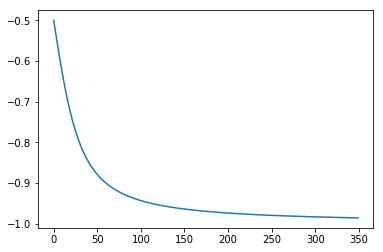

1.6047775745391846 seconds


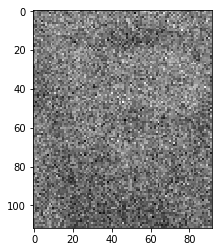

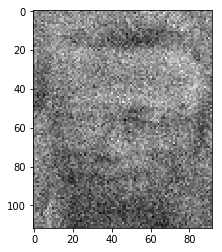

In [35]:
np_page=np.zeros((112,92))
t0 = time.time()
dream_ga=ga_norm(torch.Tensor((np_page)),net2,350,1e-1,attacked_person)
print('{} seconds'.format(time.time() - t0))
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0CPU,cmap='gray')
plt.show()

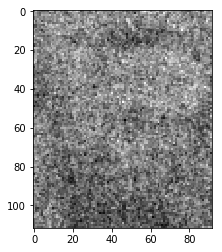

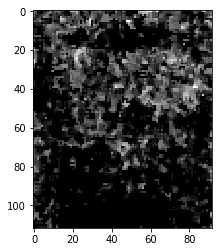

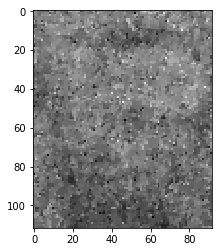

In [39]:
from skimage import restoration
from skimage import filters
img = dream_ga.squeeze().cpu().detach().numpy()
gaussian_filtered_img = filters.gaussian(img, sigma=0.5)
med_filtered_img = filters.median(img, np.ones((3, 3)))

tv_img = restoration.denoise_tv_chambolle(img, weight=0.009)
plt.imshow(gaussian_filtered_img,cmap='gray')
plt.show()
plt.imshow(med_filtered_img,cmap='gray')
plt.show()
plt.imshow(tv_img,cmap='gray')
plt.show()
